In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from scipy.sparse import coo_matrix, vstack

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 1


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tk['track_pos'] = track['pos']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json


In [5]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))

2000
57884
134125


In [6]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


In [7]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,track_pos
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,12
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time,85
spotify:track:002PgfoyfrOGiKch4EW8Wm,Alan Menken,spotify:artist:5sy77gt4bfsLcSQ8GIe4ZZ,Jasmine Runs Away,spotify:album:29EiOQJnxWlX5nVOWQpu3u,46866,Aladdin,157
spotify:track:004skCQeDn1iLntSom0rRr,Kevin Jonas,spotify:artist:11bdWrCwHE2gCdVARdASuu,Heart and Soul,spotify:album:5iK842b9xnZblgZkRxWCFe,177773,Camp Rock 2: The Final Jam,62
spotify:track:005CGalYNgMNZcvWMIFeK8,Nelson Y Sus Estrellas,spotify:artist:5SRwYMyavJCNT2AdVMpPgi,LLorándote,spotify:album:2TfoLoZHhsL0oAYBxDi4t2,321480,Orquídea de Plata,110


In [8]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


We set strings to lower case remove all non alphabetic characters and stop-words

In [158]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
ignored_words = [
    'music', 'songs', 'playlist', 'good', 'jams', 'mix', 'lit', 'best',
    'stuff', 'quot', 'like', 'one', 'amp', 'get', 'make', 'new', 'know',
    'really', 'back', 'day', 'days', 'little', 'things', 'great', 'everything',
    'jamz', 'tunes', 'artist', 'song', 'top', 'listen', 'favorite', 'bops',
    'description', 'top', 'ever', 'mostly', 'enjoy', 'bunch', 'track',
    'tracks', 'collection', 'need', 'every', 'favorites', 'may', 'got',
    'right', 'let', 'better', 'made'
]


def word_cleanup(df_col):
    df_col = df_col.apply(lambda x: x.lower())
    df_col = df_col.str.replace('[^a-z]+', ' ')
    df_col = df_col.apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored_words)]))
    df_col = df_col.str.replace(r'\b\w{1,2}\b', '').str.replace(r'\s+', ' ')
    return df_col


playlist_df.playlist_description = word_cleanup(
    playlist_df.playlist_description)
playlist_df.playlist_name = word_cleanup(playlist_df.playlist_name)

#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
#playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
#pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

In [ ]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_name.get_feature_names())
visualizer.fit(dt_mat_name)
visualizer.poof()

In [ ]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_description.get_feature_names())
visualizer.fit(dt_mat_description)
visualizer.poof()

In [ ]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

In [ ]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

In [9]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [10]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,track_pos,playlist_pid,track_uri,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,12,371,spotify:track:000mA0etY38nKdvf1N04af,false,,3675883,1496793600,quiet,15,14,4,1,15
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,5,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,3675883,1496793600,quiet,15,14,4,1,15
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,179,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,3675883,1496793600,quiet,15,14,4,1,15
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,14,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,3675883,1496793600,quiet,15,14,4,1,15
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,84,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,3675883,1496793600,quiet,15,14,4,1,15


In [11]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

In [12]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [13]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)
dataset.loc[:,'playlist_pid'] = dataset.playlist_pid.astype(str)
dataset = dataset[list(tracks_df.columns)+['track_uri']+list(playlist_df.columns)+['match']]

In [14]:
dataset.playlist_pid.dtype

dtype('O')

In [51]:
### Include the features in the list below
# features = [
#     'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
#     'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
#     'playlist_pid', 'track_duration_ms'
# ]
# data_x = dataset[features]
data_x = dataset.loc[:, dataset.columns != 'match']
data_y = dataset.match
data_train, data_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size=0.1,
    stratify=dataset.playlist_pid,
    # stratify=dataset.match,
    random_state=42,
    shuffle=True)

In [52]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        # if self.key == 'playlist_pid': from IPython.core.debugger import set_trace; set_trace()
        return data_dict[:,[self.key]].astype(np.int64)

    def get_feature_names(self):
        return [dataset.columns[self.key]]

In [53]:
# %%time

# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()


def build_preprocessor(field):
    field_idx = list(dataset.columns).index(field)
    # if field == 'playlist_pid': from IPython.core.debugger import set_trace; set_trace()
    return lambda x: default_preprocessor(x[field_idx])


vectorizer = FeatureUnion([
    (
        'track_artist_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_artist_uri'))),
    (
        'track_album_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_album_uri'))),
    (
        'track_uri',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('track_uri'))),

    (
        'playlist_pid',
        CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r".+",
            stop_words=None,
            # max_features=50000,
            preprocessor=build_preprocessor('playlist_pid'))),

    ("playlist_name",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_name"))),
    
    ("playlist_description",
      CountVectorizer(
            ngram_range=(1, 1),
            token_pattern=r"(?u)\b\w+\b",
            stop_words=None,
            analyzer = 'word',
            # max_features=50000,
            preprocessor=build_preprocessor("playlist_description"))),
#     (
#         'track_pos',
#         CountVectorizer(
#             ngram_range=(1, 1),
#             token_pattern=r".+",
#             stop_words=None,
#             # max_features=50000,
#             preprocessor=build_preprocessor('track_pos'))),

    ('track_duration_ms',
     ItemSelector(list(dataset.columns).index('track_duration_ms'))),
])
X_train = vectorizer.fit_transform(data_train.values)
# X_train

In [54]:
X_train.shape

(241425, 105962)

In [55]:
X_test = vectorizer.transform(data_test.values)
X_test.shape

(26825, 105962)

In [38]:
# %%time
# Basic cross-validation with Grid Search CV
AdaModel = AdaBoostClassifier()
parameters = {
    'n_estimators': range(50, 200, 50),
    'learning_rate': np.arange(0.01, 0.09, 0.01)
}
clf = GridSearchCV(
    AdaModel,
    parameters,
    n_jobs=-1,
    verbose=20,
    cv=KFold(2, shuffle=True),
    scoring=make_scorer(accuracy_score))
clf.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV] learning_rate=0.01, n_estimators=150 ............................
[CV] learning_rate=0.02, n_estimators=50 .............................
[CV] learning_rate=0.02, n_estimators=50 .............................
[CV]  learning_rate=0.01, n_estimators=50, score=0.5053202253773152, total= 9.2min
[CV] learning_rate=0.02, n_estimators=100 ............................
[CV]  learning_rate=0.02, n_estimators=50, score=0.5284650697114617, total= 9.2min


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.2min


[CV] learning_rate=0.02, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=50, score=0.5166900988411725, total= 9.2min
[CV] learning_rate=0.02, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  9.2min


[CV]  learning_rate=0.02, n_estimators=50, score=0.5273623892297206, total= 9.2min
[CV] learning_rate=0.02, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  9.3min


[CV]  learning_rate=0.01, n_estimators=100, score=0.5279857701279197, total=18.9min
[CV] learning_rate=0.03, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 19.0min


[CV]  learning_rate=0.01, n_estimators=100, score=0.5273623892297206, total=19.0min
[CV] learning_rate=0.03, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 19.1min


[CV]  learning_rate=0.01, n_estimators=150, score=0.5284650697114617, total=28.7min
[CV] learning_rate=0.03, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 28.7min


[CV]  learning_rate=0.02, n_estimators=100, score=0.528603534035596, total=19.5min
[CV] learning_rate=0.03, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 28.8min


[CV]  learning_rate=0.03, n_estimators=50, score=0.5273623892297206, total= 9.8min
[CV] learning_rate=0.03, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 28.8min


[CV]  learning_rate=0.02, n_estimators=100, score=0.5273623892297206, total=19.6min
[CV] learning_rate=0.03, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 28.8min


[CV]  learning_rate=0.03, n_estimators=50, score=0.5284650697114617, total= 9.7min
[CV] learning_rate=0.04, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 28.8min


[CV]  learning_rate=0.01, n_estimators=150, score=0.5273623892297206, total=28.8min
[CV] learning_rate=0.04, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 28.9min


[CV]  learning_rate=0.02, n_estimators=150, score=0.5295940865082492, total=29.7min
[CV] learning_rate=0.04, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 39.0min


[CV]  learning_rate=0.04, n_estimators=50, score=0.528603534035596, total=10.2min
[CV] learning_rate=0.04, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 39.1min


[CV]  learning_rate=0.04, n_estimators=50, score=0.5273623892297206, total=10.2min
[CV] learning_rate=0.04, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 39.1min


[CV]  learning_rate=0.02, n_estimators=150, score=0.5276712678936605, total=29.8min
[CV] learning_rate=0.04, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 39.1min


[CV]  learning_rate=0.03, n_estimators=100, score=0.5301266416010736, total=20.0min
[CV] learning_rate=0.05, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 48.8min


[CV]  learning_rate=0.03, n_estimators=100, score=0.5276606169052488, total=20.0min
[CV] learning_rate=0.05, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 48.8min


[CV]  learning_rate=0.05, n_estimators=50, score=0.5293278089618371, total= 9.7min
[CV] learning_rate=0.05, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 58.5min


[CV]  learning_rate=0.05, n_estimators=50, score=0.5274582481254261, total= 9.7min
[CV] learning_rate=0.05, n_estimators=100 ............................


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 58.5min


[CV]  learning_rate=0.03, n_estimators=150, score=0.5310319852588751, total=29.7min
[CV] learning_rate=0.05, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 58.5min


[CV]  learning_rate=0.04, n_estimators=100, score=0.5309361253421666, total=19.4min
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV]  learning_rate=0.04, n_estimators=100, score=0.533337593728698, total=19.5min
[CV] learning_rate=0.060000000000000005, n_estimators=50 .............


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 58.6min


[CV]  learning_rate=0.03, n_estimators=150, score=0.5334441036128152, total=29.8min
[CV] learning_rate=0.060000000000000005, n_estimators=50 .............


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 58.6min


[CV]  learning_rate=0.060000000000000005, n_estimators=50, score=0.5296047376101057, total=11.9min
[CV] learning_rate=0.060000000000000005, n_estimators=100 ............


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 70.5min


[CV]  learning_rate=0.04, n_estimators=150, score=0.535164612779192, total=31.4min
[CV] learning_rate=0.060000000000000005, n_estimators=100 ............


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 70.6min


[CV]  learning_rate=0.060000000000000005, n_estimators=50, score=0.527692569870484, total=12.0min
[CV] learning_rate=0.060000000000000005, n_estimators=150 ............


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 70.6min


[CV]  learning_rate=0.04, n_estimators=150, score=0.5351376107702794, total=31.5min
[CV] learning_rate=0.060000000000000005, n_estimators=150 ............


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 70.7min


[CV]  learning_rate=0.05, n_estimators=100, score=0.5304568257586247, total=24.8min
[CV] learning_rate=0.06999999999999999, n_estimators=50 ..............


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 83.3min


[CV]  learning_rate=0.05, n_estimators=100, score=0.5339020961145194, total=24.9min
[CV] learning_rate=0.06999999999999999, n_estimators=50 ..............


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 83.4min


[CV]  learning_rate=0.06999999999999999, n_estimators=50, score=0.5280120995228357, total= 8.3min
[CV]  learning_rate=0.05, n_estimators=150, score=0.5363255828815491, total=33.1min
[CV] learning_rate=0.06999999999999999, n_estimators=100 .............
[CV] learning_rate=0.06999999999999999, n_estimators=100 .............


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 91.7min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 91.7min


[CV]  learning_rate=0.06999999999999999, n_estimators=50, score=0.5295940865082492, total= 8.3min
[CV] learning_rate=0.06999999999999999, n_estimators=150 .............


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 91.7min


[CV]  learning_rate=0.060000000000000005, n_estimators=100, score=0.5316817024721208, total=21.1min
[CV] learning_rate=0.06999999999999999, n_estimators=150 .............
[CV]  learning_rate=0.05, n_estimators=150, score=0.5353825835037491, total=33.1min
[CV] learning_rate=0.08, n_estimators=50 .............................
[CV]  learning_rate=0.060000000000000005, n_estimators=100, score=0.5351376107702794, total=21.2min
[CV] learning_rate=0.08, n_estimators=50 .............................


[Parallel(n_jobs=-1)]: Done  36 out of  48 | elapsed: 91.8min remaining: 30.6min


[CV]  learning_rate=0.08, n_estimators=50, score=0.5333588957055214, total= 8.2min
[CV] learning_rate=0.08, n_estimators=100 ............................
[CV]  learning_rate=0.08, n_estimators=50, score=0.5311811006848659, total= 8.2min
[CV] learning_rate=0.08, n_estimators=100 ............................
[CV]  learning_rate=0.060000000000000005, n_estimators=150, score=0.5365279538168224, total=29.2min
[CV] learning_rate=0.08, n_estimators=150 ............................


[Parallel(n_jobs=-1)]: Done  39 out of  48 | elapsed: 100.0min remaining: 23.1min


[CV]  learning_rate=0.060000000000000005, n_estimators=150, score=0.5375979890933879, total=29.4min
[CV] learning_rate=0.08, n_estimators=150 ............................
[CV]  learning_rate=0.06999999999999999, n_estimators=100, score=0.535974096520285, total=16.7min
[CV]  learning_rate=0.06999999999999999, n_estimators=100, score=0.5352760736196319, total=16.8min


[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed: 108.5min remaining: 15.5min


[CV]  learning_rate=0.06999999999999999, n_estimators=150, score=0.5371137644189291, total=24.6min
[CV]  learning_rate=0.08, n_estimators=100, score=0.536410791696401, total=16.4min
[CV]  learning_rate=0.06999999999999999, n_estimators=150, score=0.5388548057259713, total=24.7min


[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed: 116.5min remaining:  7.8min


[CV]  learning_rate=0.08, n_estimators=100, score=0.5374701772324472, total=16.5min
[CV]  learning_rate=0.08, n_estimators=150, score=0.5376250173080405, total=23.6min
[CV]  learning_rate=0.08, n_estimators=150, score=0.5395364689843217, total=23.6min


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 123.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 123.7min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(50, 200, 50), 'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=20)

In [40]:
clf.best_params_

{'learning_rate': 0.08, 'n_estimators': 150}

In [56]:
%%time
# Train the model
AdaModel = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                             n_estimators=150, learning_rate=0.08)
AdaModel = AdaModel.fit(X_train, y_train)
y_pred = AdaModel.predict(X_train)


CPU times: user 6min 47s, sys: 4.17 s, total: 6min 51s
Wall time: 6min 57s


In [57]:
print(accuracy_score(y_train, y_pred))

1.0


In [60]:
%%time
y_test_pred = AdaModel.predict(X_test)
print(accuracy_score(y_test, y_test_pred))

0.7081826654240447
CPU times: user 112 ms, sys: 4.59 ms, total: 117 ms
Wall time: 118 ms


In [61]:
print(data_test.shape)
print(X_test.shape)

(26825, 19)
(26825, 105962)


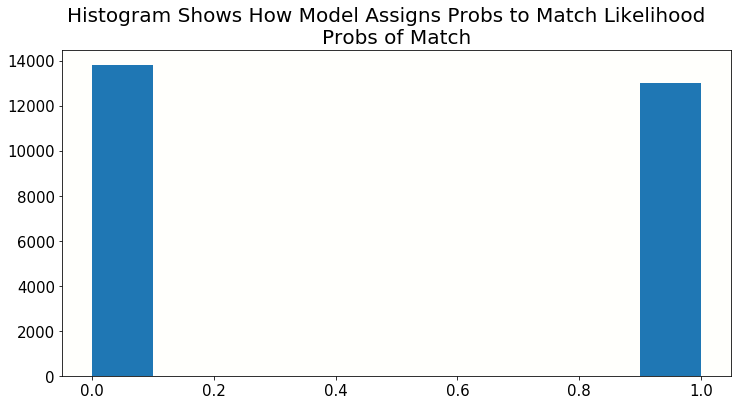

In [102]:
plt.rcParams["axes.facecolor"] = (1,1,.99) 
plt.rcParams["font.size"] = 15 
plt.rcParams["figure.figsize"] = (12,6) 
plt.rcParams["ytick.labelsize"] = 15 
plt.rcParams["xtick.labelsize"] = 15 
plt.rcParams["lines.linewidth"] = 2 
plt.rcParams["axes.titlesize"] = 20

#Histogram of probability predictions
probs = AdaModel.predict_proba(X_test)

fig, ax = plt.subplots(1,1, figsize = (12,6))
fig.suptitle("Histogram Shows How Model Assigns Probs to Match Likelihood", fontsize = 20)


ax.hist(probs[: ,1])
ax.set_title("Probs of Match")
ax.grid(alpha = 0)

In [103]:
#Get important features and visual for features
#get top feature indices and ratings

importances = AdaModel.feature_importances_
indices = np.argsort(importances)[::-1]

top50index = []
top50importance = []
for f in range(50):
    top50index.append(indices[f])
    top50importance.append(importances[indices[f]])

In [104]:
#helper in getting top features and making visual
#convert relevant dataframe columns to lowercase so we can compare with top feature output

track_artist_lower_df = tracks_df["track_artist_uri"].apply(lambda x: x.lower())
track_album_lower_df = tracks_df["track_album_uri"].apply(lambda x: x.lower())
merged_track_uri_lower_df = merged["track_uri"].apply(lambda x: x.lower())

#Take a uri and return album, artist or song title in plain english
def get_translation(uri_type, uri):
    
    track = False  #if a single track/song is input as uri, I need to handle it differently
    if uri_type == "track_artist_uri":
        df = track_artist_lower_df
        col = "track_artist_name"
    elif uri_type == "track_album_uri":
        df = track_album_lower_df
        col = "track_album_name"
    elif uri_type == "track_uri":
        df = merged_track_uri_lower_df
        col = "track_name"
        track = True   #Handle track_name differently by going to the merged df
    for i in range(len(tracks_df)):
        if df[i] == uri:
            if track == True:
                return merged.iloc[i][col]
            return tracks_df.iloc[i][col]
            break


In [106]:
#Make list of top features
feature_names = []

#Loop through the indices of top features and append them to a list in plain english, not uri info
for i in top50index:
    feature = vectorizer.get_feature_names()[i].split("__")
    if feature[0] == "track_artist_uri":
        feature_names.append("Artist = " + get_translation("track_artist_uri", feature[1]))
    elif feature[0] == "track_album_uri":
        feature_names.append("Album = " + get_translation("track_album_uri", feature[1]))
    elif feature[0] == "track_uri":
        feature_names.append("Song = " + get_translation("track_uri", feature[1].lstrip()))
    
    else:
        feature_names.append(feature[0] + "_" + feature[1])

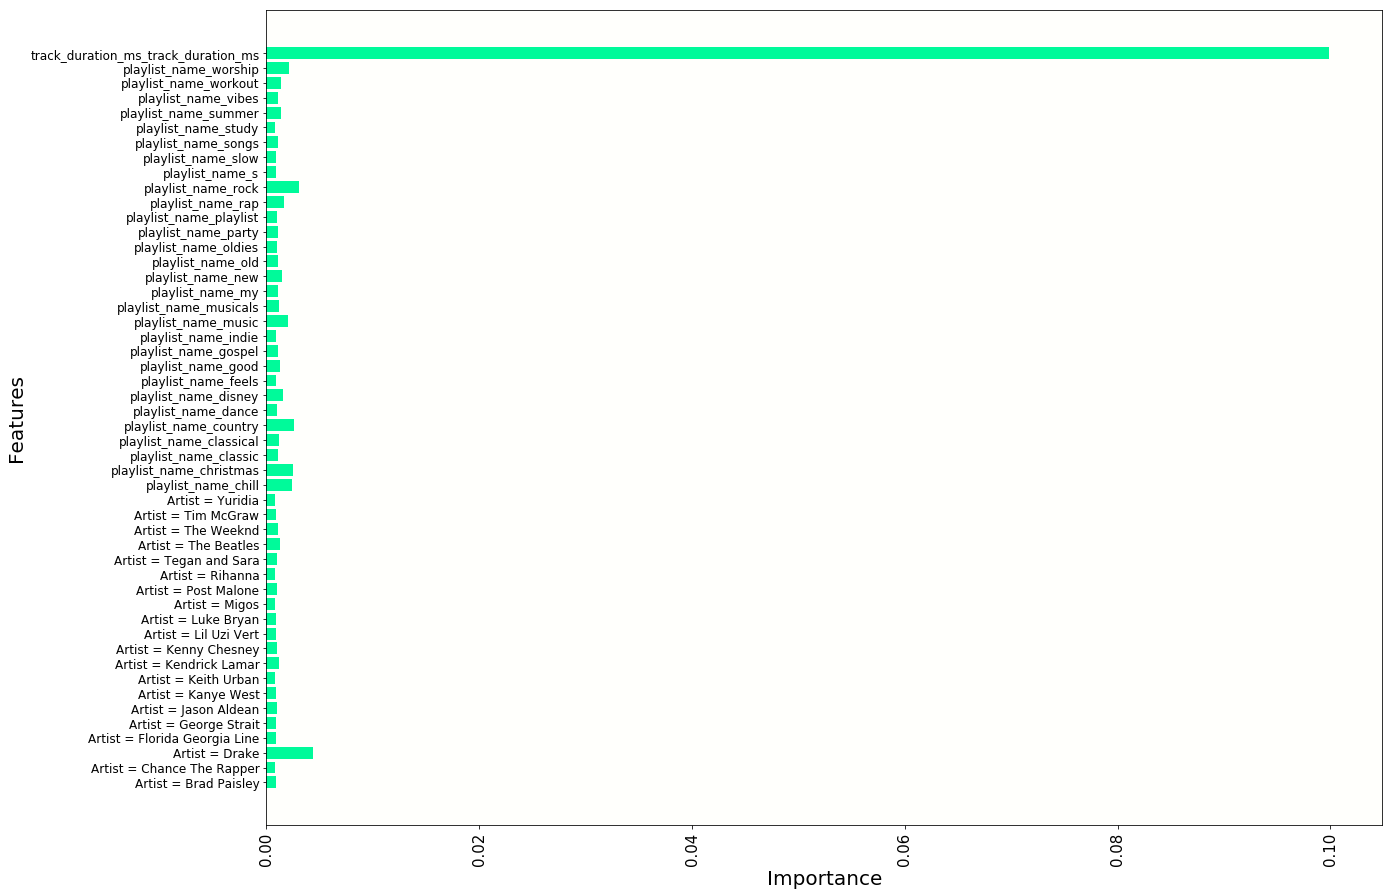

In [107]:
#plot

fig, ax = plt.subplots(1,1, figsize = (20,15))
y_pos = np.arange(len(feature_names))
ax.barh(feature_names, top50importance, align = "center", color = "mediumspringgreen")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid(alpha = 0)
ax.set_xlabel("Importance", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=15)

fig.savefig("Feature Importance.png", bbox_inches="tight")

In [108]:
#Check for relevant features besides playlist_pid numbers
not_pid_features = []
not_pid_importances = []
for feature in feature_names:
    if "playlist_pid" not in feature:
        not_pid_features.append(feature)
        idx = feature_names.index(feature)
        not_pid_importances.append(top50importance[idx])

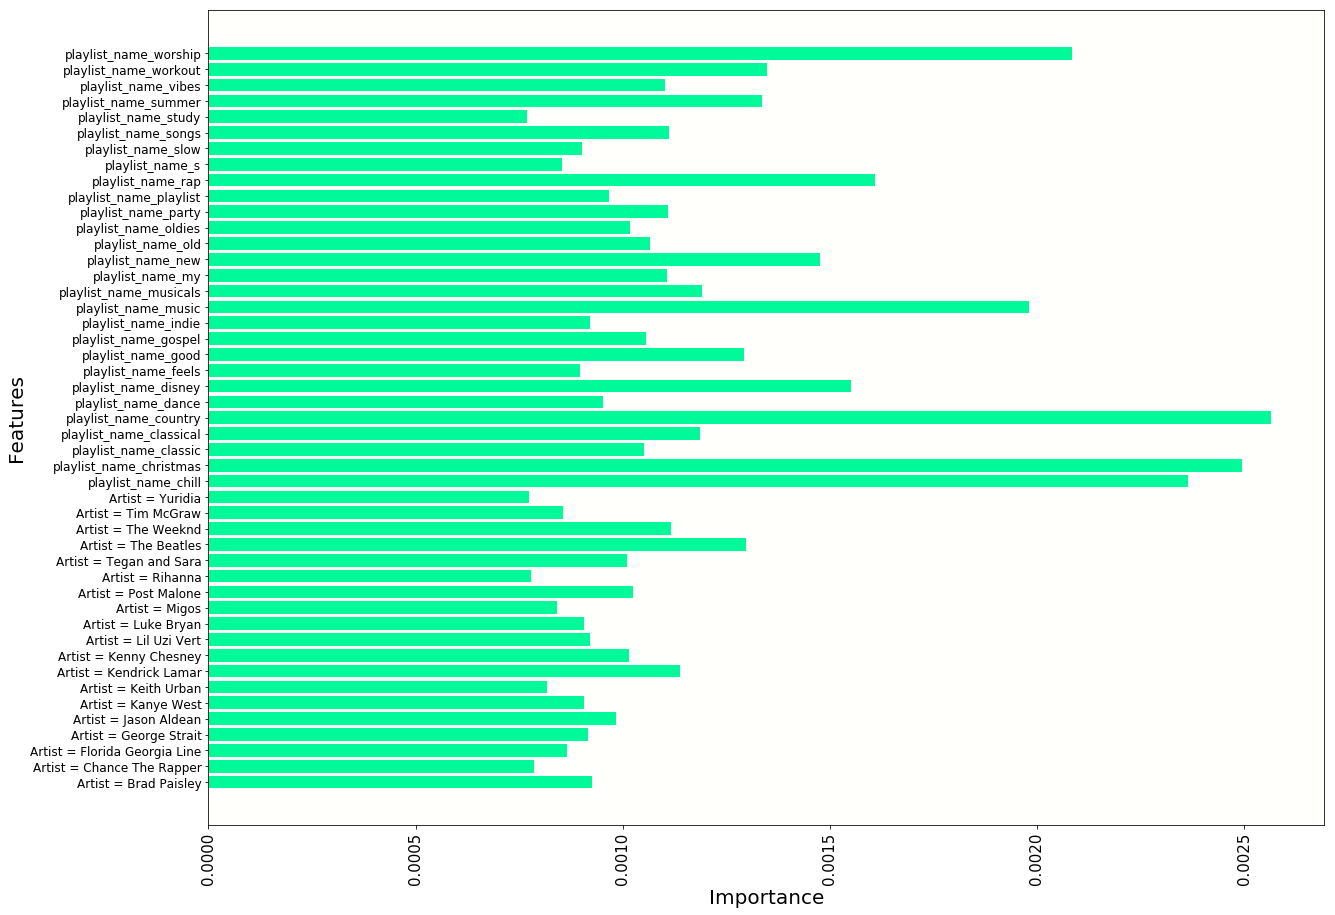

In [109]:
#plot important features except for playlist_pid
fig, ax = plt.subplots(1,1, figsize = (20,15))
y_pos = np.arange(len(not_pid_features) - 3)
ax.barh(not_pid_features[3:], not_pid_importances[3:], align = "center", color = "mediumspringgreen")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid(alpha = 0)
ax.set_xlabel("Importance", fontsize = 20)
ax.set_ylabel("Features", fontsize = 20)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=15)

fig.savefig("Feature Importance.png", bbox_inches="tight")

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(data_test.groupby(['playlist_pid']))
for pid, df in pbar:
    p_info = df[playlist_df.columns].iloc[0]
    # from IPython.core.debugger import set_trace; set_trace()
    labels = y_test.loc[df.index]
    
    # Positive Tracks
    positive_tracks_idx = labels[labels == 1].index
    positive_tracks = data_test.loc[positive_tracks_idx]
    sp_positive_tracks = vectorizer.transform(positive_tracks.values)
    
    # Negative Tracks
    negative_tracks_idx = ~np.isin(data_test.index, positive_tracks_idx)
    negative_tracks = data_test[negative_tracks_idx].drop(
        playlist_df.columns, axis=1)
    negative_playlist = np.array([p_info.values] * len(negative_tracks))
    negative_playlist_samples = np.hstack([negative_tracks, negative_playlist])
    sp_negative_tracks = vectorizer.transform(negative_playlist_samples)
    # from IPython.core.debugger import set_trace; set_trace()
    
    # Test Tracks
    test_tracks = vstack([sp_negative_tracks, sp_positive_tracks])
    index_order = negative_tracks.index.append(positive_tracks_idx)
    
    # Predict, r_precision
    y_prob = AdaModel.predict_proba(test_tracks)
    # from IPython.core.debugger import set_trace; set_trace()
    y_pred = np.argsort(-y_prob[:,1])
    best_pred = index_order[y_pred]
    if len(positive_tracks_idx) > 0:
        r_precisions.append(r_precision(positive_tracks_idx, best_pred))
    pbar.set_description("{}".format(np.mean(r_precisions)))


In [101]:
def get_track_predictions(playlist_name, top_tracks=10):
    """
    Function to get track predictions for a single playlist
    playlist_name should be in the form of a string.
    """
    for pid, df in pbar:
        p_info = df[playlist_df.columns].iloc[0]
        if p_info.playlist_name == playlist_name: 
            labels = y_test.loc[df.index]

            # Positive Tracks
            positive_tracks_idx = labels[labels == 1].index
            positive_tracks = data_test.loc[positive_tracks_idx]
            sp_positive_tracks = vectorizer.transform(positive_tracks.values)

            # Negative Tracks
            negative_tracks_idx = ~np.isin(data_test.index, positive_tracks_idx)
            negative_tracks = data_test[negative_tracks_idx].drop(
                playlist_df.columns, axis=1)
            negative_playlist = np.array([p_info.values] * len(negative_tracks))
            negative_playlist_samples = np.hstack([negative_tracks, negative_playlist])
            sp_negative_tracks = vectorizer.transform(negative_playlist_samples)
            # from IPython.core.debugger import set_trace; set_trace()

            # Test Tracks
            test_tracks = vstack([sp_negative_tracks, sp_positive_tracks])
            index_order = negative_tracks.index.append(positive_tracks_idx)

            # Predict, r_precision
            y_prob = AdaModel.predict_proba(test_tracks)
            # from IPython.core.debugger import set_trace; set_trace()
            y_pred = np.argsort(-y_prob[:,1])
            best_pred = index_order[y_pred]
            if len(positive_tracks_idx) > 0:
                print(r_precision(positive_tracks_idx, best_pred))
                print(data_test.loc[best_pred[:10]].loc[:,['track_artist_name','track_name']])
            break
get_track_predictions('Throwbacks', top_tracks=10)

0.2
            track_artist_name                    track_name
48                      Ne-Yo                        Closer
38312             Tame Impala                    Eventually
47038        Childish Gambino              Me and Your Mama
8784               Sylo Nozra                 Losing Myself
52077              Ed Sheeran                       Happier
96082                  G-Eazy                         Rebel
186172                  Drake                    Free Smoke
27395          Mumford & Sons                       Monster
9031                  The Him  Feels Like Home - Radio Edit
79366   Red Hot Chili Peppers                   Scar Tissue


The dataset has been split, which is great. However, in order to better simulate real world situations, we need to build a test set with a lot more negative samples than there are positive samples. In the split above, there are equal number of positive and negative samples, so it'll be easy for the algorithm to perform. Below we build a more robust test set

In [ ]:
# Interacting with the Spotify API to obtain a real playlist from it.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials()
client_credentials_manager = SpotifyClientCredentials('35eaae57b15449448c0821785c790c82', '070ec29c07ac41879aee8d3a57d05f15')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
results = sp.search(q='Slow Brain Waves', type=['playlist'], limit=20)


In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)

https://stackoverflow.com/questions/49018652/how-to-combine-labelbinarizer-and-onehotencoder-in-pipeline-in-python-for-catego 
